# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [3]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_superconduct
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct-gamma-limit"

nb_devices_for_the_run = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Handling non-iid data

No missing value. Great !
Scaling data.
There is 81 dimensions.
Head of the dataset:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.080058          0.046733             -0.451651   
1            0.614744          0.174269             -0.432071   
2           -0.080058          0.046733             -0.450978   
3           -0.080058          0.046733             -0.451314   
4           -0.080058          0.046733             -0.452324   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          -0.158850              -0.611819             0.044358   
1           0.059368              -0.604180             0.777430   
2          -0.158850              -0.611658             0.044358   
3          -0.158850              -0.611739             0.044358   
4          -0.158850              -0.611980             0.044358   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                -0.003707           0.1337

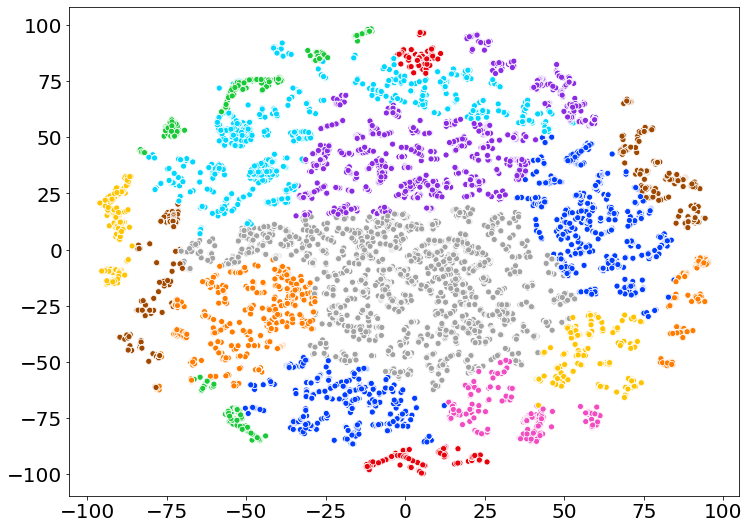

In [4]:
%%time
X, Y, dim_notebook = prepare_superconduct(nb_devices_for_the_run, iid=False)

In [7]:
from src.utils.data.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Changing : 
(241, 13)
(4763, 17)
Number of points on device 0 : 1860
Number of points on device 1 : 1548
Number of points on device 2 : 569
Number of points on device 3 : 386
Number of points on device 4 : 604
Number of points on device 5 : 582
Number of points on device 6 : 434
Number of points on device 7 : 813
Number of points on device 8 : 820
Number of points on device 9 : 1604
Number of points on device 10 : 1257
Number of points on device 11 : 389
Number of points on device 12 : 302
Number of points on device 13 : 2622
Number of points on device 14 : 2512
Number of points on device 15 : 658
Number of points on device 16 : 388
Number of points on device 17 : 2382
Number of points on device 18 : 482
Number of points on device 19 : 1051


In [8]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X_r, Y_r, nb_devices_for_the_run)

In [9]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   


KeyboardInterrupt: 

In [11]:
step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

label_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

## Batch size $= 50$ (stochastic)

In [12]:
%%time
batch_size = 50

all_kind_of_compression_res = []
all_descent_various_gamma = {}
descent_by_algo_and_step_size = {}

#Corresponds to descent with optimal gamma for each algorithm
optimal_descents = {}

for type_params in tqdm(KIND_COMPRESSION):
    losses_by_comp = []
    losses_avg_by_comp = []
    descent_by_step_size = {}
    for (formula, label) in zip(step_formula, label_step_formula):
        multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                                   use_averaging=True, stochastic=True, batch_size=batch_size, 
                                                   step_formula=formula,
                                                   compression_model = SQuantization(1, dim_notebook + 1),
                                                   nb_epoch=250, logs_file="{0}.txt".format(filename))
        
        descent_by_step_size[label] = multiple_sg_descent
        losses_by_formula, losses_avg_by_formula = [], []
        
        # Picking the minimum values for each of the run.
        for sequence_of_losses, sequence_of_losses_avg in zip(multiple_sg_descent.losses, multiple_sg_descent.averaged_losses):
            losses_by_formula.append(min(sequence_of_losses))
            losses_avg_by_formula.append(min(sequence_of_losses_avg))
        losses_by_comp.append(losses_by_formula)
        losses_avg_by_comp.append(losses_avg_by_formula)
        
    descent_by_algo_and_step_size[type_params.name()] = ResultsOfSeveralDescents(descent_by_step_size, nb_devices_for_the_run)
    
    # Find optimal descent for the algo:
    min_loss_desc = 10e12
    opt_desc = None
    for desc in descent_by_step_size.values():
        if min_loss_desc > min([desc.losses[j][-1] for j in range(len(desc.losses))]):
            min_loss_desc = min([desc.losses[j][-1] for j in range(len(desc.losses))])
            opt_desc = desc
    # Adding the optimal descent to the dict of optimal descent
    optimal_descents[type_params.name()] = opt_desc
    
    artificial_multiple_descent = MultipleDescentRun()
    artificial_multiple_descent.append_list(losses_by_comp, losses_avg_by_comp)
    all_descent_various_gamma[type_params.name()] = artificial_multiple_descent
    all_kind_of_compression_res.append(all_descent_various_gamma)
    
res_various_gamma = ResultsOfSeveralDescents(all_descent_various_gamma, nb_devices_for_the_run)
pickle_saver(res_various_gamma, "{0}-alldescent".format(filename))

res_opt_gamma = ResultsOfSeveralDescents(optimal_descents, nb_devices_for_the_run)
pickle_saver(res_opt_gamma, "{0}-optimal_descents".format(filename))

pickle_saver(descent_by_algo_and_step_size, "{0}-descent_by_algo_and_step_size".format(filename))

  0%|          | 0/5 [00:16<?, ?it/s]


KeyboardInterrupt: 

## Without averaging

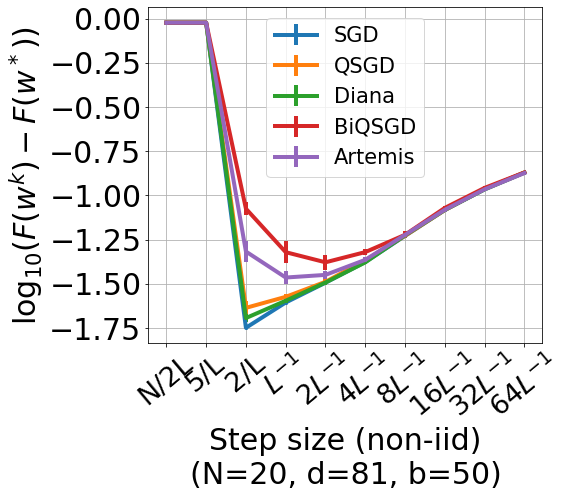

In [12]:
batch_size = 50
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Step size (non-iid)", one_on_two_points=False,
               xlabels=label_step_formula)

## With averaging

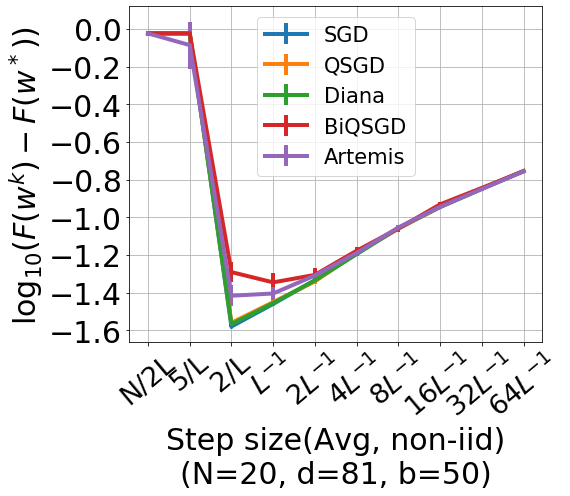

In [13]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size(Avg, non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 

### Display loss for each algorithm

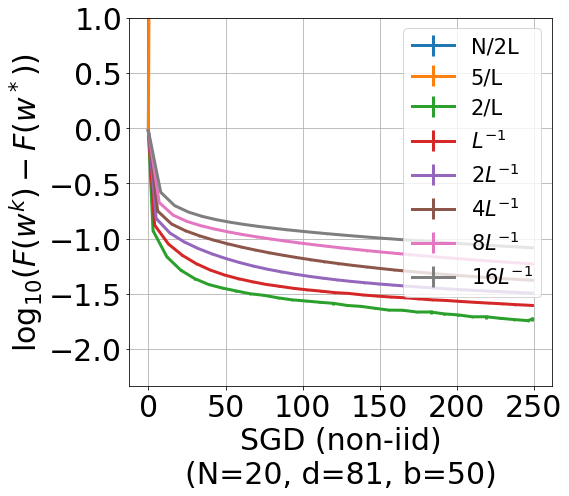

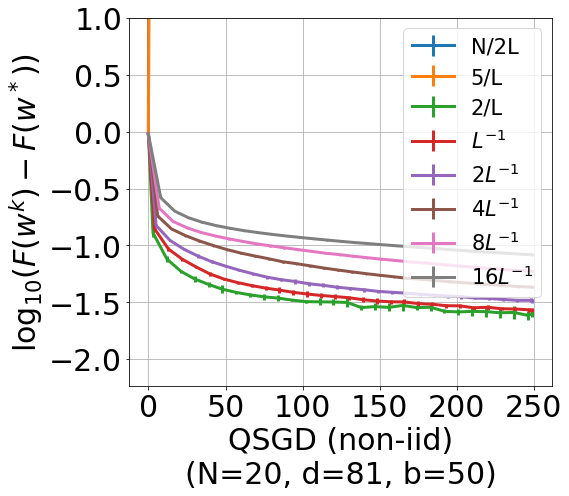

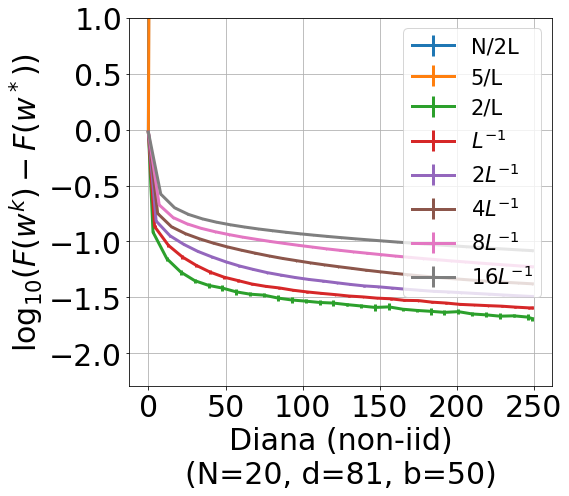

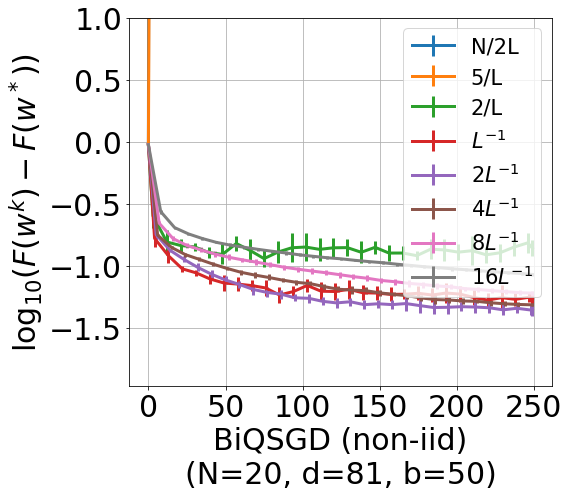

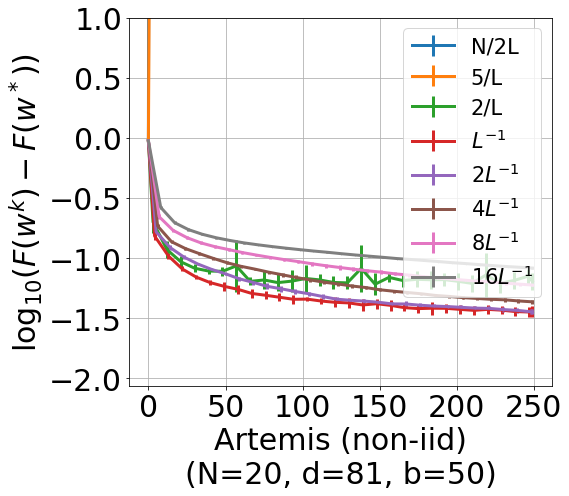

In [14]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_step_size".format(filename))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name),
                   ylim=True) 


### Display algo with its optimal step size

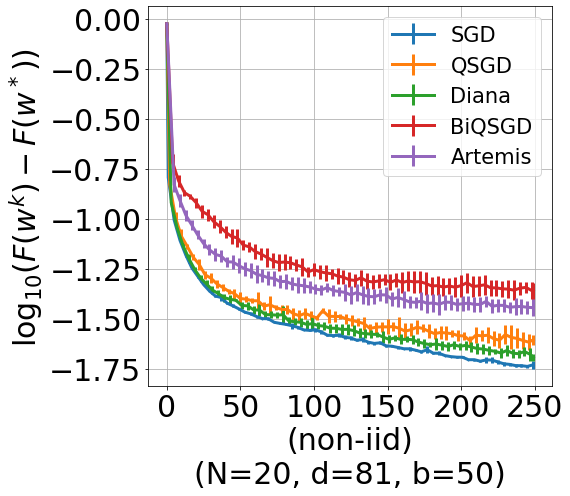

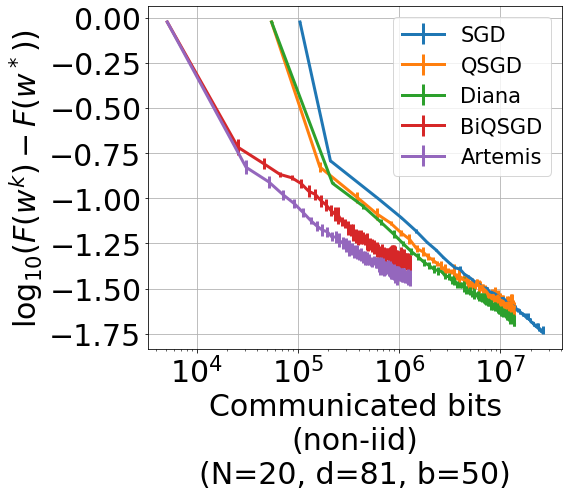

In [15]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-optimal_descents".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj), batch_size=batch_size,
                x_legend="(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 